In [1]:
# Import required libraries
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

# Convert labels to integers
y = y.astype(int)

# Convert dataframes to arrays
X = X.to_numpy()
y = y.to_numpy()

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

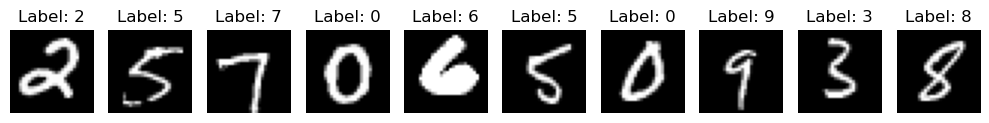

In [4]:
# Function to display random images
def plot_mnist_samples(X, y, num_samples=10):
    """
    Plots a grid of random sample images from the MNIST dataset.
    X: Feature matrix (flattened images).
    y: Labels corresponding to the images.
    num_samples: Number of images to display.
    """
    indices = np.random.choice(len(X), num_samples, replace=False)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 random images
plot_mnist_samples(X, y, num_samples=10)

In [5]:
subsample_size=20000

In [6]:
print('Starting Shape:',X.shape)
# Step 2: Preprocess the data
# Normalize pixel values (0-255) to (0-1)
X = X / 255.0

# Reduce dimensionality using PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)

# Subsample the data (10,000 cases for training)
subsample_indices = np.random.choice(len(X_pca), subsample_size, replace=False)
X_subsample = X_pca[subsample_indices]
y_subsample = y[subsample_indices]

print('Shape after transforming:',X_subsample.shape)

# Create an out-of-sample test set using the remaining indices
out_of_sample_indices = np.setdiff1d(np.arange(len(X_pca)), subsample_indices)
X_out_of_sample = X_pca[out_of_sample_indices]
y_out_of_sample = y[out_of_sample_indices]

# Split the subsample into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_subsample, y_subsample, test_size=0.2, stratify=y_subsample, random_state=42
)

# Optional: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_out_of_sample = scaler.transform(X_out_of_sample)

Starting Shape: (70000, 784)
Shape after transforming: (20000, 154)


In [7]:
# Step 3: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.03, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


SVC(C=10, gamma=0.01, random_state=42)

Training Accuracy: 100.00%
Validation Accuracy: 96.12%
Out-of-Sample Test Accuracy: 95.91%
Classification Report (Out-of-Sample Test Data):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4976
           1       0.99      0.98      0.98      5661
           2       0.91      0.97      0.94      4959
           3       0.96      0.94      0.95      5101
           4       0.96      0.96      0.96      4909
           5       0.96      0.94      0.95      4492
           6       0.98      0.96      0.97      4896
           7       0.98      0.95      0.97      5218
           8       0.91      0.97      0.94      4787
           9       0.97      0.93      0.95      5001

    accuracy                           0.96     50000
   macro avg       0.96      0.96      0.96     50000
weighted avg       0.96      0.96      0.96     50000



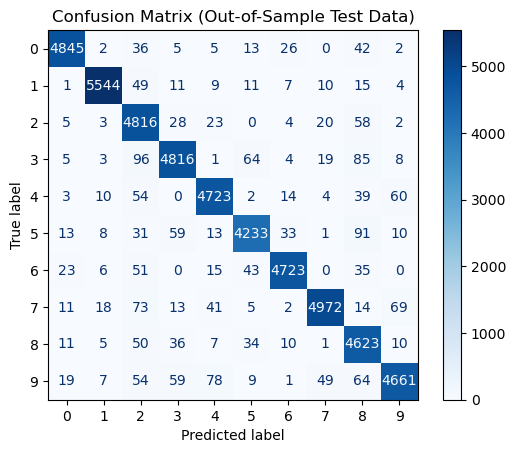

In [8]:
# Step 4: Evaluate the model
y_pred_train = best_svm_model.predict(X_train)
y_pred_test = best_svm_model.predict(X_test)
y_pred_out_of_sample = best_svm_model.predict(X_out_of_sample)

# Training, testing, and out-of-sample accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
out_of_sample_accuracy = accuracy_score(y_out_of_sample, y_pred_out_of_sample)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")
print(f"Out-of-Sample Test Accuracy: {out_of_sample_accuracy * 100:.2f}%")

# Print classification report for out-of-sample test set
print("Classification Report (Out-of-Sample Test Data):")
print(classification_report(y_out_of_sample, y_pred_out_of_sample))

# Plot confusion matrix for out-of-sample test set
ConfusionMatrixDisplay.from_estimator(best_svm_model, X_out_of_sample, y_out_of_sample, cmap='Blues')
plt.title("Confusion Matrix (Out-of-Sample Test Data)")
plt.show()